<a href="https://colab.research.google.com/github/Donnie-Stewart/Sign_Language_Detector/blob/main/Sign_language_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

# Sign Language Detector

The goal of this project is to compare **Convolutional Neural Networks** tasked with detecting each letter of the ASL alphabet. Experiments and design is listed by the following:



*   Process a corpus of ASL data. 
*   Train a CNN from scratch. 
  * Conduct tests for Hyperparameter Tuning. 
*   Create a comparison model via Transfer Learning. 
*   Detailed comparison between models. 





## Gesture Recognition using Convolutional Neural Networks


American Sign Language (ASL) is a complete, complex language that employs signs made by moving the hands combined with facial expressions and postures of the body. It is the primary language of many North Americans who are deaf and is one of several communication options used by people who are deaf or hard-of-hearing.

The hand gestures representing English alphabet are shown below. For this project, I will focus on classifying these hand gesture images using convolutional neural networks. Specifically, given an image of a hand showing one of the letters, I want to detect which letter is being represented.

![](https://drive.google.com/uc?export=view&id=1bj2AP4R7bCV1CYDgSx193u4MqJG2SITM)







In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
import zipfile
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1tcCJtyPTF8yjsi2D2-LVKYEmF7NMrGcj'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('data.zip')

zip_ref = zipfile.ZipFile("data.zip", 'r')
with zipfile.ZipFile('./data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')
zip_ref.close()

###Part A) Process a corpus of ASL data.

Code cell above links to the data folder in my drive. Extracting yields "asl_alphabet_train" and "asl_alphabet_test". 

Below Porcesses the data: 
  - Organizes the 29 folders of data into 29 separate classes e.g. 'a-z', 'del', 'nothing', and 'space'.
  - I wanted to rescale the pixel values of the training and test images from [0,255] to [0,1]. But found most convenient place was the first layer of the network. 
  - Ensured all of imges are of size $200\times 200$. If one wasn't it would get re-scaled here. 


In [2]:
from os import listdir
from os.path import isfile, join
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
#used tf docs and this tutorial https://www.tensorflow.org/tutorials/load_data/images
train_path = "./asl_alphabet_train/asl_alphabet_train"

training_images = tf.keras.utils.image_dataset_from_directory(
    train_path, 
    validation_split=0.2,
    subset="training",
    label_mode='categorical', #for categorical croos entropy loss
    color_mode='rgb', 
    batch_size=16, 
    image_size=(200, 200), 
    shuffle=True, 
    seed=123,
)
validation_images = tf.keras.utils.image_dataset_from_directory(
    train_path, 
    validation_split=0.2,
    subset="validation",
    label_mode='categorical', 
    color_mode='rgb', 
    batch_size=16, 
    image_size=(200, 200), 
    shuffle=True, 
    seed=123,
)


Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.


### Part B) Building and Training a Convolutional Neural Network from scratch

---


#### Step 1) Building the Network
- CNN takes ($200\times 200$ RGB) image as input. 
- Maps each color channel to be between 0/1
- Extracts features with Conv2D layers
- Reduces dimensionality with pooling layers
- Flatten layer is used convert matrix to dense input. 
- Dense layers are used to predict classes based on feature extraction. 
- Predicts on the 29 classes. 


#### Step 2) Training the Network
Hyperparameter tuning is a significant challenge of training a model from scratch. Having a function that meakes it easy to tweak parameters and plot results is very helpful.


In [4]:
def train_CNN(train_data,val_data, opt="adam", a='relu', e=5, l=tf.losses.CategoricalCrossentropy(), filter=32, kernel=3):

    model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape = (200,200,3)),
    tf.keras.layers.Conv2D(filter, kernel, activation=a),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(filter+32, kernel, activation=a),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(filter, kernel, activation=a),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=a),
    tf.keras.layers.Dense(29, activation = 'softmax'),
    ])

    model.compile( optimizer=opt, loss=l, metrics=['accuracy'])

    history = model.fit( train_data, validation_data=val_data, epochs=e, verbose = 0)

    return history 


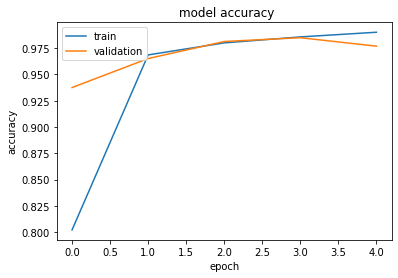

[0.8021408319473267, 0.968635082244873, 0.9800718426704407, 0.9857615232467651, 0.9902011752128601]


In [5]:
hist = train_CNN( training_images, validation_images)
# print(model.summary())

plt.plot(hist.history['accuracy'] )
plt.plot(hist.history['val_accuracy'] )

plt.title(' model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(["train", "validation"], loc='upper left')
plt.show()
print(hist.history["accuracy"])

When searching for the loss function I read through the tensorflow documentation for the most likely candidate. I set up the data for categorical input in one-hot encoded form and the corresponding loss function is categorical_cross_entropy(). I chose the adam optimizer mainly because in reasearching other models and tutorials I found it to be the most common. Then, when I tested it myself it consistently outperformed the other optimizers. Filter sizes in powers of 2 are expected to have more efficient performance based one some blog posts online. 

Lastly, the model from scratch can achieve >99% accuracy on this dataset when tested on 29 classes for 5 epochs. 

#### Step 3) Overfit to A Small Dataset

One way to sanity check the neural network model and training code is to check whether the model is capable of overfitting or memorizing a small dataset. A properly constructed CNN with correct training code should be able to memorize the answers to a small number of images quickly.

After constructing a small sample of the dataset, I retrain the model in the exact same way for many epochs to see if my model from scratch can memorize all of the labels. 


With a large batch size (e.g. the entire small dataset) and a learning rate that is not too high, the model should be able to obtain a 100% training accuracy on that small dataset relatively quickly.

In [6]:
#small set 
small_set = training_images.take(20) #20 batches of data (20*16 = image amount)
history = train_CNN( small_set, small_set, e = 50)
#if 1.0 in train and val return true
if 1.0 in history.history["val_accuracy"] and 1.0 in history.history["accuracy"]:
    print("sanity check passed")

sanity check passed


#### Step 4) Hyperparameter Search

 Here I test and plot 3 hyperparameters - amount of filters, kernal size, and optimizers. I tested 4 instances of each using the helper function above. After plotting and determining the best in each category, I updated the defaults to the helper function above. More specific details are below. 







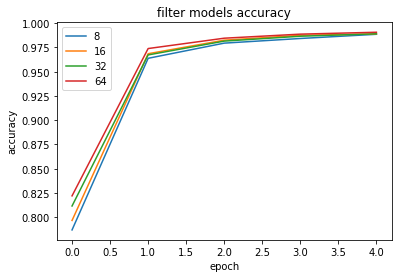

In [7]:
######### filter tests ###############
filters = [8,16,32,64]
f_history = []
for f in filters:
    f_history.append(train_CNN( training_images, validation_images, filter=f))
for fh in f_history:
    plt.plot(fh.history['accuracy'])
plt.title('filter models accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([str(f) for f in filters], loc='upper left')
plt.show()


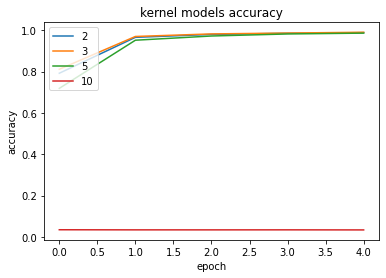

In [8]:
#### kernel tests ###################
kernels = [2,3,5,10]
k_history = []
for k in kernels:
    k_history.append(train_CNN( training_images, validation_images, kernel=k))

for kh in k_history:
    plt.plot(kh.history['accuracy'])
plt.title('kernel models accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([str(k) for k in kernels], loc='upper left')
plt.show()

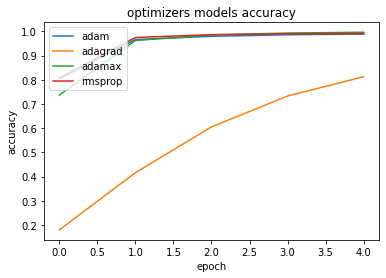

In [9]:
####### optimizers #########
opt = ['adam', 'adagrad', 'adamax', 'rmsprop']
o_history = []
for o in opt:
    o_history.append(train_CNN( training_images, validation_images, opt=o))

for oh in o_history:
    plt.plot(oh.history['accuracy'])
plt.title('optimizers models accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([o for o in opt], loc='upper left')
plt.show()


I tested filters, kernels, and different optimizers. The best model I found was using the adam optimizer, 3x3 kernel, and 32 filters. For the optimizer and kernel tests, most values I tried were in a very tight range but with one outlier each. The outliers were adagrad and 10x10  respectively. I opted to test filters in increasing powers of 2, because one source described potential efficiency benefits of doing so. When testing the various filters, 32 had the best accuracy and in this test the difference between the best and second best accuracy was the most dramatic. The best accuracy I achieved is approx 99.05 and that value is printed above. 

Transfer Learning
---
For many image classification tasks, it is generally not a good idea to train a very large deep neural network model from scratch due to the enormous compute requirements and lack of sufficient amounts of training data.

One of the better options is to try using an existing model that performs a similar task to the one you need to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed Transfer Learning. Using Transfer Learning to extract features from the hand gesture images, then training a smaller network to use these features as input and classify the hand gestures - is how transfer learning is applied to this use case. Additionaly, this process works by utilizing heavily trained convolution layers to extract the necessary features from the images which then get processed by fully-connected layers for the new tasks classification. 



Keras even has pretrained models built in for this purpose. 

#### Keras Pretrained Models
        Xception
        VGG16
        VGG19
        ResNet, ResNetV2, ResNeXt
        InceptionV3
        InceptionResNetV2
        MobileNet
        MobileNetV2
        DenseNet
        NASNet

Usually one uses the layers of the pretrained model up to some point, and then creates some fully connected layers to learn the desired recognition task. The earlier layers are "frozen", and only the later layers need to be trained. For this task I'll use VGG16, which was trained to recognize 1000 objects in ImageNet. 

In [10]:
from tensorflow.keras.layers import Input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

Creating this pretrained network is a one line command. Notice how it is specified that the "top" should not be included. The top layer is exluded because I am classifying only 29 classes, rather than the 1000 categories in ImageNet.  I will add my own layer more suited to the task at hand.


In [11]:
# Import the VGG16 trained neural network model, minus its last (top) neuron layer.
base_model = VGG16(weights = 'imagenet', 
                   include_top = False, 
                   input_shape = (200, 200, 3), 
                   pooling = None)

58900480/58889256 [==============================] - 2s 0us/step


A summary of this pretrained model:

In [12]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

This base model is sufficient for the purposes of this task thus all the weights for every layer can be frozen. This saves siginificant time and computational power. 

In [13]:
# This freezes the weights of our VGG16 pretrained model.
for layer in base_model.layers:  
    layer.trainable = False

### Part A) Building the Classifier
All that is necessary to create a new model is adding a flatten layer, a trainable dense layer, and a final softmax layer to the network to complete the classifier model for our gesture recognition task. This approach uses the Keras' functional approach to building a network.

In [15]:
# Adds layers to the pre-trained base model and adds the classification layers on top of it

x =  tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(29, activation = 'softmax')(x)

model = Model(inputs = base_model.input, outputs = x) 

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

### Part B) Initializing Training Parameters

Compile the model using an appropriate loss function and optimizer.

In [16]:
# Compile the model.
model.compile(optimizer = 'adam', loss = tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])

### Part C) Training the Model



In [17]:
# Preprocess the input image data

final_training = training_images.map(lambda x, y: (x*(1./255), y))
final_validation = validation_images.map(lambda x, y: (x*(1./255), y))

In [18]:
# Train the model

history = model.fit( final_training, validation_data=final_validation, epochs=3)

Epoch 1/3
4350/4350 [==============================] - 201s 46ms/step - loss: 1.3302 - accuracy: 0.5626 - val_loss: 0.7630 - val_accuracy: 0.7625
Epoch 2/3
4350/4350 [==============================] - 199s 46ms/step - loss: 0.5858 - accuracy: 0.8175 - val_loss: 0.5107 - val_accuracy: 0.8375
Epoch 3/3
4350/4350 [==============================] - 199s 46ms/step - loss: 0.3871 - accuracy: 0.8866 - val_loss: 0.3094 - val_accuracy: 0.9163


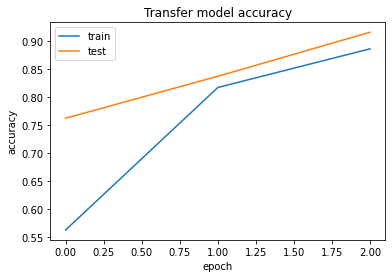

[0.5626437067985535, 0.8174569010734558, 0.8866091966629028]


In [19]:
# Plot the training curve

plt.plot(history.history['accuracy'] )
plt.plot(history.history['val_accuracy'] )

plt.title('Transfer model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(["train", "test"], loc='upper left')
plt.show()
print(history.history["accuracy"])

### Part D) The Best Transferred Classifier



Epoch 1/3
4350/4350 [==============================] - 177s 41ms/step - loss: 0.3654 - accuracy: 0.9048 - val_loss: 0.0913 - val_accuracy: 0.9703
Epoch 2/3
4350/4350 [==============================] - 174s 40ms/step - loss: 0.0435 - accuracy: 0.9875 - val_loss: 0.0187 - val_accuracy: 0.9945
Epoch 3/3
4350/4350 [==============================] - 175s 40ms/step - loss: 0.0269 - accuracy: 0.9914 - val_loss: 0.0082 - val_accuracy: 0.9982
Epoch 1/3
4350/4350 [==============================] - 176s 40ms/step - loss: 0.3418 - accuracy: 0.9096 - val_loss: 0.0743 - val_accuracy: 0.9775
Epoch 2/3
4350/4350 [==============================] - 175s 40ms/step - loss: 0.0426 - accuracy: 0.9873 - val_loss: 0.0404 - val_accuracy: 0.9858
Epoch 3/3
4350/4350 [==============================] - 176s 40ms/step - loss: 0.0295 - accuracy: 0.9903 - val_loss: 0.0245 - val_accuracy: 0.9919
Epoch 1/3
4350/4350 [==============================] - 177s 40ms/step - loss: 0.3585 - accuracy: 0.9056 - val_loss: 0.0654 -

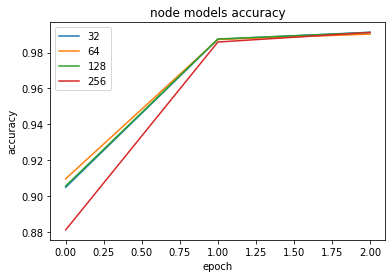

In [ ]:
n_history = []
nodes = [32,64,128,256]
for n in nodes:
    z = 0
    z =  tf.keras.layers.Flatten()(base_model.output)
    z = tf.keras.layers.Dense(128, activation='relu')(z)
    z = tf.keras.layers.Dense(len(classes), activation = 'softmax')(z)
    temp = Model(inputs = base_model.input, outputs = z) 
    temp.compile(optimizer = 'adam', loss = tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])
    n_history.append( temp.fit( final_training, validation_data=final_validation, epochs=3))


for nh in n_history:
    plt.plot(nh.history['accuracy'])
plt.title('node models accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([str(n) for n in nodes], loc='upper left')
plt.show()

Best accuracy achieved was 99.14 but all node amounts I tried in the dense layer were within a very small margin of that number. 

#Conclusion:
---

After searching for the best model from scratch and comparing the process to utilizing transfer learning for sign language detection here is what I learned. First, there are insanely capable models that need almost no training for challenging tasks, and are accessible in one line of code. These models are likely larger than one you may attempt to train yourself thus requiring more memory, but is advantageous when getting started. At the very least, these pre-trained models should be considered as a baseline comparison when implementing a model for a new specific task. In this case, the models both achieved > 99% validation accuracy on detecting the correct sign language gestures which is likely due to well labeled data within a massive corpus to train on (87000 labeled images were used between training and validation). The process of determining the best hyperparameters is also a challenge when training from scratch and should be considered an added cost to be aware of. The main take away from this project is well labeled data is far more important that any model design. Later applications can include using these models to predict per frame of a video of someone gesturing all of the signs. Testing on a real world scenario will uncover whether the models require improvement. 

# Credits:

Distinguished Professor at University of California at Santa Cruz [Narges Norouzi](https://nargesnorouzi.me/) 
